In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from scipy.fft import rfft, rfftfreq

In [4]:
df = pd.read_pickle("../../data/raw/df_resample_100ms.pkl")

In [5]:
df

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,subject_id,trial,age,height,weight,gender
timestamp,,,,,,,,,,,,,
1970-01-01 00:38:38.700,0.948777,-9.636166,0.002699,0.003818,0.016875,0.006643,BSC,1.0,1.0,32.0,180.0,85.0,M
1970-01-01 00:38:38.800,0.948993,-9.759188,0.087482,0.020693,0.027565,0.015669,BSC,1.0,1.0,32.0,180.0,85.0,M
1970-01-01 00:38:38.900,1.071514,-9.787465,-0.093610,0.168721,0.075747,0.037797,BSC,1.0,1.0,32.0,180.0,85.0,M
1970-01-01 00:38:39.000,1.135679,-9.754036,0.065878,0.339488,0.078970,0.040134,BSC,1.0,1.0,32.0,180.0,85.0,M
1970-01-01 00:38:39.100,1.126174,-9.443248,0.075006,0.594494,-0.012065,0.103557,BSC,1.0,1.0,32.0,180.0,85.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 04:49:55.200,2.128992,14.084110,0.907692,-1.022787,0.162796,0.609964,WAL,67.0,1.0,23.0,180.0,67.0,M
1970-01-01 04:49:55.300,-1.563028,11.139874,1.061856,-2.417346,-0.699792,1.861551,WAL,67.0,1.0,23.0,180.0,67.0,M
1970-01-01 04:49:55.400,2.767679,8.869539,0.154884,-0.998184,0.612194,1.557859,WAL,67.0,1.0,23.0,180.0,67.0,M


### Feature Extraction

In [6]:
def energy_entropy(signal, num_blocks=10):
    """
    Example placeholder function for energy entropy.
    Adjust or replace as needed.
    """
    # compute energy in each block, then compute Shannon entropy
    block_size = len(signal) // num_blocks
    energies = []
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = signal[start:end]
        energies.append(np.sum(block**2))

    energies = np.array(energies)
    energies_norm = energies / (np.sum(energies) + 1e-10)
    entropy_val = -np.sum(energies_norm * np.log2(energies_norm + 1e-10))
    return entropy_val

The features that will be generated by the function defined below are:

1. Stat features of both sensors data: mean, std, min, max, skew, kurtosis, min-max diff for each axis

2. The Slope (SL) of the three accelerometer axes

3. Tilt angle (T_Ai) between gravitational vector and y-axis, as wll as stats of this tilt accross each window

4. The magnitude of each axis from both sensors

5. Statistical features for those magnitude computed

6. Incorporate 10 block entropy of energy for accelerometer magnitude (strongest feature in MobiFall paper)

In [7]:
def extract_features_from_windows(df, window_duration_s=2.5, overlap=0.5, sampling_rate_ms=100):
    """
    Slide a window over each trial of each subject to extract aggregated features.
    All features are aggregated over each window, including the magnitude features.
    """
    window_size = int(window_duration_s * 1000 / sampling_rate_ms)
    step_size = int(window_size * (1 - overlap))
    
    features = []
    labels = []
    
    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject]
        
        for trial in subject_data['trial'].unique():
            trial_data = subject_data[subject_data['trial'] == trial].sort_index()
            # 6D signals: [acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z]
            signal_data = trial_data[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values
            class_labels = trial_data['label'].values
            
            for start in range(0, len(signal_data) - window_size + 1, step_size):
                window = signal_data[start:start + window_size]
                window_labels = class_labels[start:start + window_size]
                # Use one label for the entire window; for example, the last one:
                label = window_labels[-1]
                
                # ---------------- Aggregated Statistical Features ----------------
                mean_feat = window.mean(axis=0)
                std_feat  = window.std(axis=0)
                min_feat  = window.min(axis=0)
                max_feat  = window.max(axis=0)
                skew_feat = skew(window, axis=0)
                kurt_feat = kurtosis(window, axis=0)
                minmax_diff = max_feat - min_feat

                # ---------------- Slope Computation for Accelerometer ----------------
                acc_x = window[:, 0]
                acc_y = window[:, 1]
                acc_z = window[:, 2]
                acc_slope = np.sqrt(
                    (acc_x.max() - acc_x.min())**2 +
                    (acc_y.max() - acc_y.min())**2 +
                    (acc_z.max() - acc_z.min())**2
                )
                
                # ---------------- Tilt Angle Statistics ----------------
                # Tilt angle: T_Ai = arcsin( acc_y / sqrt(acc_x^2 + acc_y^2 + acc_z^2) )
                magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
                tilt_angles = np.arcsin(acc_y / (magnitude + 1e-8))
                tilt_mean = tilt_angles.mean()
                tilt_std  = tilt_angles.std()
                tilt_skew = skew(tilt_angles)
                tilt_kurt = kurtosis(tilt_angles)
                
                # ---------------- Accelerometer and Gyroscope Magnitude Aggregations ----------------
                acc_mag = np.sqrt(np.sum(window[:, :3] ** 2, axis=1))   # instantaneous values per sample
                gyro_mag = np.sqrt(np.sum(window[:, 3:] ** 2, axis=1))
                
                # Aggregated stats for accelerometer magnitude
                acc_mag_mean = acc_mag.mean()
                acc_mag_std  = acc_mag.std()
                acc_mag_min  = acc_mag.min()
                acc_mag_max  = acc_mag.max()
                acc_mag_diff = acc_mag_max - acc_mag_min
                acc_mag_energy_entropy = energy_entropy(acc_mag, num_blocks=10)
                
                # Aggregated stats for gyroscope magnitude
                gyro_mag_mean = gyro_mag.mean()
                gyro_mag_std  = gyro_mag.std()
                gyro_mag_min  = gyro_mag.min()
                gyro_mag_max  = gyro_mag.max()
                gyro_mag_diff = gyro_mag_max - gyro_mag_min

                # ---------------- Combine All Aggregated Features into a Single Feature Row ----------------
                feat = np.concatenate([
                    mean_feat,        # aggregated mean for 6 channels
                    std_feat,         # aggregated standard deviation
                    min_feat,         # minimum values per channel
                    max_feat,         # maximum values per channel
                    skew_feat,        # skew per channel
                    kurt_feat,        # kurtosis per channel
                    minmax_diff,      # difference between max and min for each channel
                    [acc_slope],      # slope of accelerometer values
                    [tilt_mean, tilt_std, tilt_skew, tilt_kurt],
                    [acc_mag_mean, acc_mag_std, acc_mag_min, acc_mag_max, acc_mag_diff, acc_mag_energy_entropy],
                    [gyro_mag_mean, gyro_mag_std, gyro_mag_min, gyro_mag_max, gyro_mag_diff]
                ])
                
                features.append(feat)
                labels.append(label)
                
    return features, labels


In [8]:
import pandas as pd

# Extract features from the windows
features, labels = extract_features_from_windows(df)

# Base sensor names
sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Statistical measures to calculate for each sensor
stats = ['mean', 'std', 'min', 'max', 'skew', 'kurt']
stat_columns = [f"{stat}_{sensor}" for stat in stats for sensor in sensors]

# Min-max diff (range) for each sensor
minmax_diff_cols = [f"{sensor}_range" for sensor in sensors]

# Slope (just one column for accelerometer slope)
slope_col = ['acc_slope']

# Tilt stats (angle features)
tilt_cols = ['tilt_mean', 'tilt_std', 'tilt_skew', 'tilt_kurt']

# Magnitude stats 
acc_mag_stats = ['acc_mag_mean', 'acc_mag_std', 'acc_mag_min', 'acc_mag_max', 'acc_mag_diff', 'acc_mag_energy_entropy']
gyro_mag_stats = ['gyro_mag_mean', 'gyro_mag_std', 'gyro_mag_min', 'gyro_mag_max', 'gyro_mag_diff']

# Combine all feature names in the exact order of concatenation
column_names = (
    stat_columns + 
    minmax_diff_cols + 
    slope_col + 
    tilt_cols +  
    acc_mag_stats + 
    gyro_mag_stats
)

# Ensure the number of columns in the features matches the number of column names
assert len(column_names) == len(features[0]), f"Feature count mismatch: {len(column_names)} != {len(features[0])}"

# Create the DataFrame with the features
features_df = pd.DataFrame(features, columns=column_names)

# Add the 'label' column to the DataFrame (this is the target variable)
features_df['label'] = labels


In [9]:
# Export to assess features importance in a seperate notebook
features_df.to_pickle("../../data/processed/features_df_59.pkl")

In [10]:
features_df

,mean_acc_x,mean_acc_y,mean_acc_z,mean_gyro_x,mean_gyro_y,mean_gyro_z,std_acc_x,std_acc_y,std_acc_z,std_gyro_x,...,acc_mag_min,acc_mag_max,acc_mag_diff,acc_mag_energy_entropy,gyro_mag_mean,gyro_mag_std,gyro_mag_min,gyro_mag_max,gyro_mag_diff,label
0,0.253800,-9.735710,-0.759319,-0.052844,0.018417,0.029541,0.245499,0.014139,0.217480,0.028723,...,9.735512,9.809990,0.074478,3.321924,0.090548,0.039731,0.028844,0.229268,0.200424,STD
1,0.249150,-9.739145,-0.733451,-0.032854,0.029329,0.011645,0.237170,0.014339,0.232159,0.031158,...,9.738685,9.809990,0.071305,3.321922,0.072513,0.046496,0.019905,0.229268,0.209363,STD
2,0.386838,-9.739573,-0.578832,-0.036421,0.003834,0.016446,0.146762,0.013975,0.088793,0.026637,...,9.730387,9.785563,0.055175,3.321926,0.056273,0.017656,0.019905,0.092863,0.072958,STD
3,0.326125,-9.741381,-0.672142,-0.049490,0.001070,0.023786,0.055841,0.011643,0.079863,0.007339,...,9.730387,9.790438,0.060051,3.321926,0.059128,0.011383,0.044413,0.092863,0.048451,STD
4,0.283808,-9.745207,-0.738642,-0.042550,0.012788,0.018867,0.027931,0.008566,0.040782,0.005152,...,9.762408,9.792928,0.030519,3.321927,0.049011,0.005093,0.039530,0.058386,0.018856,STD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69978,5.822824,-1.556491,7.235764,-0.066575,0.083216,-0.058658,1.872333,0.572352,1.382859,0.357383,...,3.617510,12.013304,8.395794,3.296561,0.490682,0.574643,0.027853,2.293158,2.265304,SIT
69979,6.218721,-2.150890,6.742830,0.040020,0.044249,0.119265,1.445265,0.697573,1.440475,0.306958,...,8.646267,10.517353,1.871086,3.319196,0.425943,0.440300,0.027853,1.416272,1.388418,CSO
69980,6.294121,-0.479762,5.933423,0.127804,0.004355,-0.142396,1.834981,4.135841,1.116061,0.857453,...,5.389208,12.161697,6.772488,3.314004,1.127563,0.727587,0.040854,2.398200,2.357346,CSO
69981,4.271851,5.092304,3.382345,0.320573,-0.384789,-0.601700,2.281468,5.606993,3.181307,1.035809,...,5.289488,13.113264,7.823775,3.252006,1.482418,1.146300,0.133865,4.501683,4.367818,STD


### 1. Define preprocessing steps

✅ Extracts features once
✅ Encodes labels

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)


In [13]:
from sklearn.preprocessing import LabelEncoder

def preprocess_dataset(df, sampling_rate_ms, window_duration_s=2.5, overlap=0.5, test_size=0.2, random_state=42):
    # Extract features and labels from windows
    X, y = extract_features_from_windows(
        df,
        window_duration_s=window_duration_s,
        overlap=overlap,
        sampling_rate_ms=sampling_rate_ms
    )

    # Label encode target
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"\n✅ Feature extraction done | Total windows: {len(y)} | Labels: {label_encoder.classes_}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(X, y_encoded)

    print(f"\n🔁 Data Split | Training: {len(y_train)} | Testing: {len(y_test)}")
    
    return X_train, X_test, y_train, y_test, label_encoder



### 2. Model Training Function

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
def train_model(X_train, y_train, model_type="random_forest", **kwargs):
    if model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42, **kwargs)
    elif model_type == "decision_tree":
        model = DecisionTreeClassifier(random_state=42, **kwargs)
    elif model_type == "knn":
        model = KNeighborsClassifier(n_neighbors=1, **kwargs)
    elif model_type == "svm":
        model = SVC(probability=True, random_state=42, **kwargs)
    elif model_type == "mlp":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, **kwargs)
    elif model_type == "logistic_regression":
        model = LogisticRegression(max_iter=200, random_state=42, **kwargs)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.fit(X_train, y_train)
    return model

### 4. Evaluation Function with Decode Labels

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

def evaluate_model(model, X_test, y_test, model_name=None, show_confusion_matrix=True, label_encoder=None):
    """
    Evaluate a multi-class classification model and print standard metrics including accuracy.
    """
    if model_name:
        print(f"\n📈 Evaluation Results for Model: {model_name}")

    y_pred = model.predict(X_test)

    # Decode labels if label_encoder is provided
    if label_encoder:
        y_test_decoded = label_encoder.inverse_transform(y_test)
        y_pred_decoded = label_encoder.inverse_transform(y_pred)
    else:
        y_test_decoded = y_test
        y_pred_decoded = y_pred

    # Calculate accuracy
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_decoded, y_pred_decoded, digits=4))

    # Confusion matrix
    if show_confusion_matrix:
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test_decoded, y_pred_decoded))

    # ROC AUC score
    try:
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
        print(f"\nROC AUC (OvR, macro): {roc_auc:.4f}")
    except AttributeError:
        print("\nROC AUC not available (predict_proba missing for this model).")
    except ValueError:
        print("\nROC AUC could not be computed (check if y_test is binary or properly encoded).")

## Running the pipeline

#### Generate training and testing data

In [19]:
X_train, X_test, y_train, y_test, label_encoder = preprocess_dataset(df, sampling_rate_ms =100)


✅ Feature extraction done | Total windows: 69983 | Labels: ['BSC' 'CHU' 'CSI' 'CSO' 'FKL' 'FOL' 'JOG' 'JUM' 'LYI' 'SCH' 'SDL' 'SIT'
 'STD' 'STN' 'STU' 'WAL']

🔁 Data Split | Training: 55986 | Testing: 13997


In [24]:
for model_type in ["knn", "logistic_regression", "decision_tree", "mlp"]:
    print(f"\n🔁 Training & Evaluating Model: {model_type}")

    X_train, X_test, y_train, y_test, label_encoder = preprocess_dataset(df, sampling_rate_ms =100)
    
    # 🛠️ Train model based on current type
    model = train_model(X_train, y_train, model_type=model_type)

    evaluate_model(
        model,
        X_test,
        y_test,
        model_name=model_type,
        label_encoder=label_encoder
     )


🔁 Training & Evaluating Model: knn

✅ Feature extraction done | Total windows: 69983 | Labels: ['BSC' 'CHU' 'CSI' 'CSO' 'FKL' 'FOL' 'JOG' 'JUM' 'LYI' 'SCH' 'SDL' 'SIT'
 'STD' 'STN' 'STU' 'WAL']

🔁 Data Split | Training: 55986 | Testing: 13997

📈 Evaluation Results for Model: knn

Accuracy: 0.8760

Classification Report:
              precision    recall  f1-score   support

         BSC     0.6447    0.5213    0.5765        94
         CHU     0.5128    0.4762    0.4938        42
         CSI     0.5418    0.5597    0.5506       243
         CSO     0.6735    0.6274    0.6496       263
         FKL     0.3846    0.3571    0.3704        70
         FOL     0.3860    0.3438    0.3636        64
         JOG     0.9354    0.9364    0.9359       959
         JUM     0.9342    0.9442    0.9392       932
         LYI     0.7702    0.7403    0.7549       851
         SCH     0.4872    0.4831    0.4851       118
         SDL     0.4783    0.4024    0.4371        82
         SIT     0.7749    0

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📈 Evaluation Results for Model: logistic_regression

Accuracy: 0.7655

Classification Report:
              precision    recall  f1-score   support

         BSC     0.4681    0.4681    0.4681        94
         CHU     0.1111    0.0238    0.0392        42
         CSI     0.4265    0.2387    0.3061       243
         CSO     0.5572    0.4259    0.4828       263
         FKL     0.5714    0.3429    0.4286        70
         FOL     0.4265    0.4531    0.4394        64
         JOG     0.8830    0.8895    0.8862       959
         JUM     0.9188    0.9227    0.9208       932
         LYI     0.3496    0.1857    0.2425       851
         SCH     0.4386    0.2119    0.2857       118
         SDL     0.3710    0.2805    0.3194        82
         SIT     0.5238    0.5709    0.5463      1002
         STD     0.7544    0.8618    0.8045      4124
         STN     0.6618    0.5422    0.5960       498
         STU     0.7579    0.4358    0.5534       553
         WAL     0.8754    0.9486    0.9

### Evaluate Random Forest (Best Model)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train =  rf_model.predict(X_train)
y_pred_test =  rf_model.predict(X_test)

In [ ]:
import joblib
# Save the trained model as a pickle file
joblib.dump(rf_model, '../../model/rf_model.pkl')

['../../model/rf_model.pkl']

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Decode LabelEncoder()
decoded_y_train = label_encoder.inverse_transform(y_train)
decoded_y_test = label_encoder.inverse_transform(y_test)
decoded_pred_train = label_encoder.inverse_transform(y_pred_train)
decoded_pred_test = label_encoder.inverse_transform(y_pred_test)

In [ ]:
# Create confusion matrices
cm_train = confusion_matrix(decoded_y_train, decoded_pred_train, labels=label_encoder.classes_)
cm_test = confusion_matrix(decoded_y_test, decoded_pred_test, labels=label_encoder.classes_)


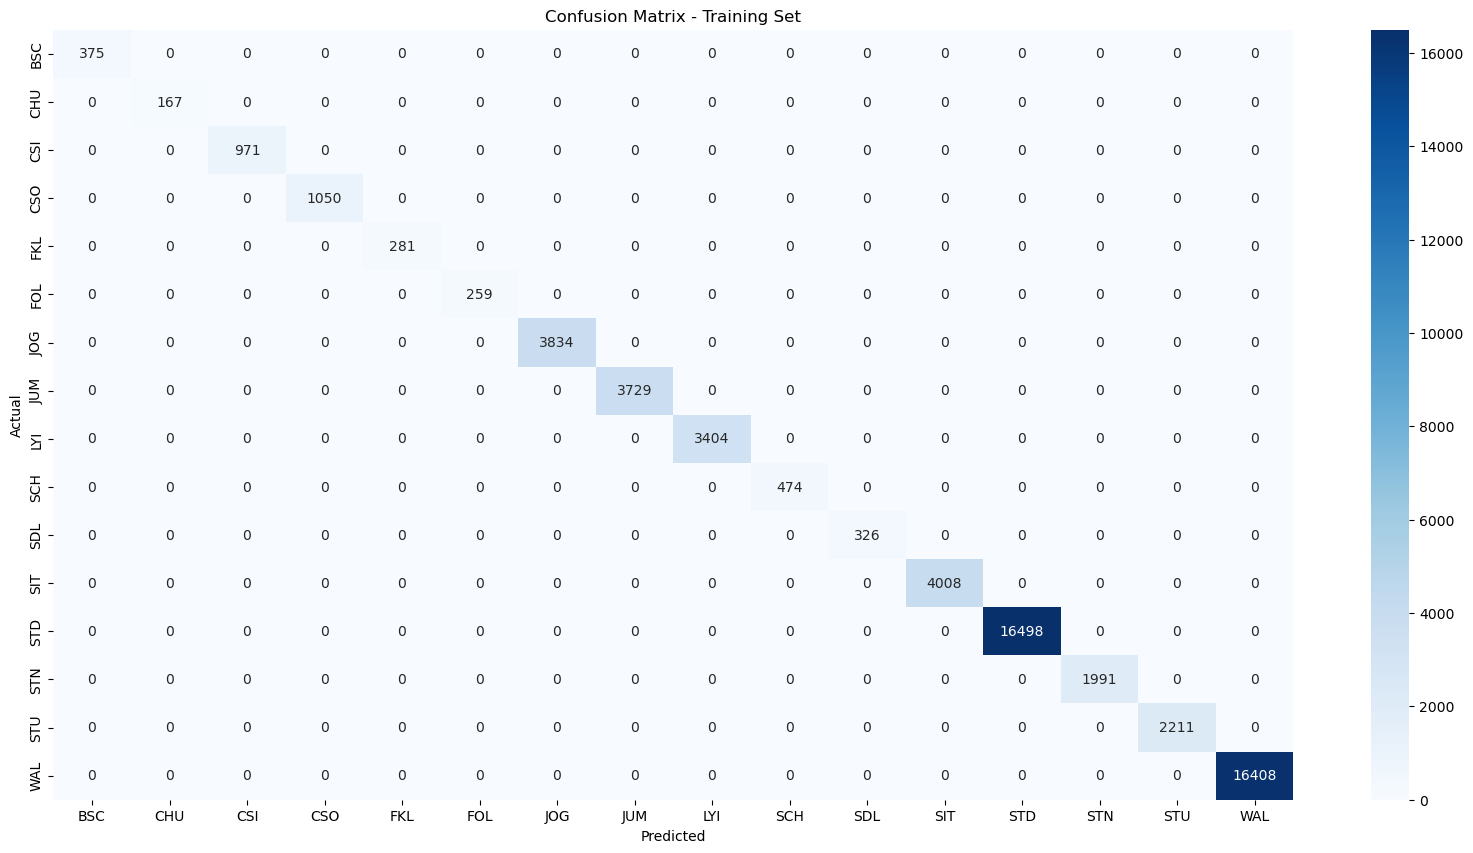

In [ ]:
# Plot training confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

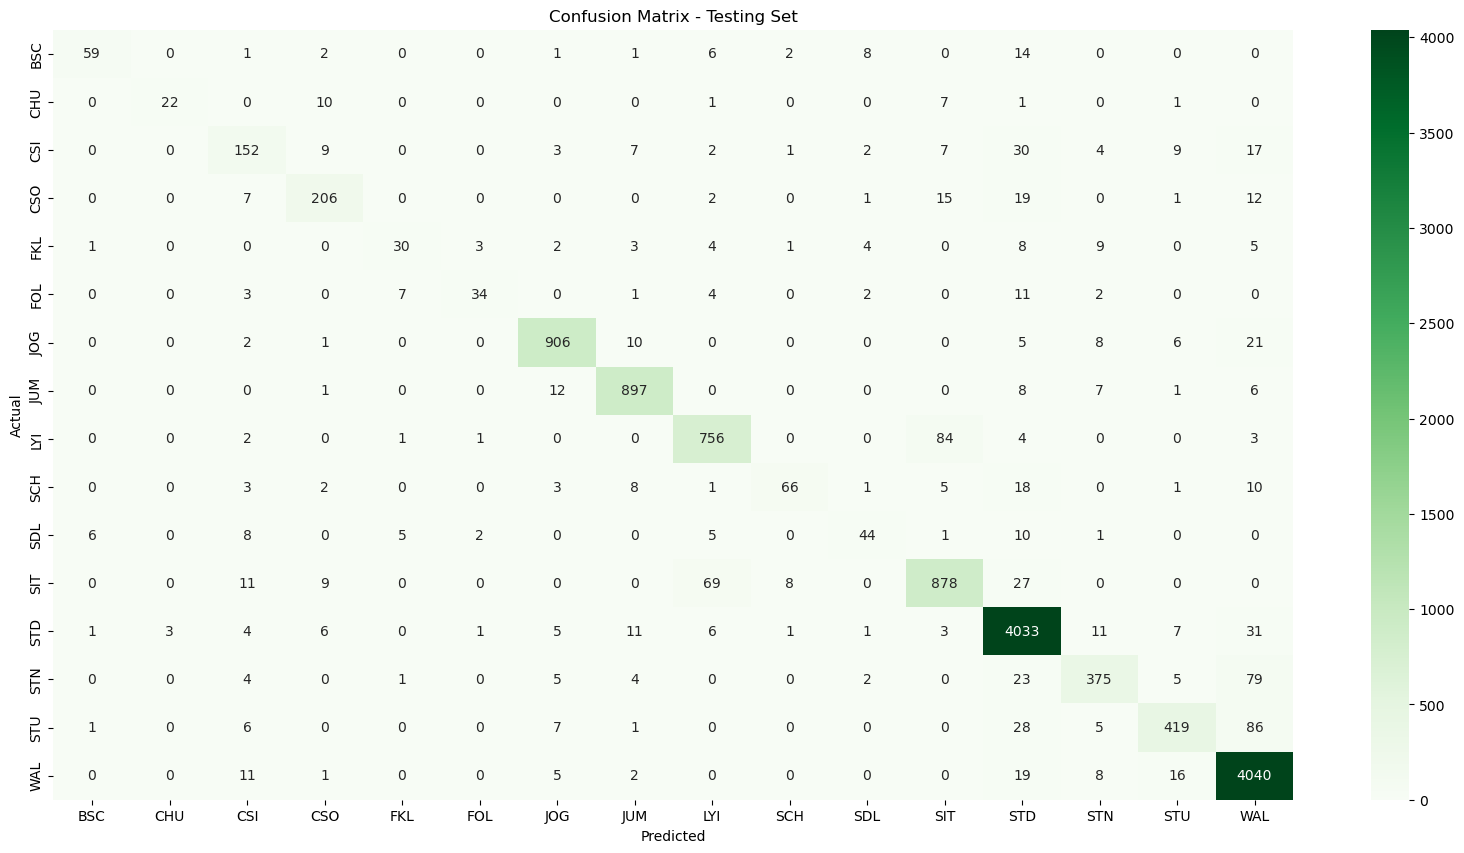

In [ ]:
# Plot testing confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()